## Generate video by convolutional LSTM network using Keras

Predicts next frame of the video contains moving squares
* Author: Gao Yang
* Note:
    * 40 minutes per epoch on Intel i5 CPU (12000 minutes for 300 epochs, too long!)
    * 2.5 minutes per epoch on Tesla K80 (Floydhub). Recommended!

#### Setup the enviorment

In [24]:
from __future__ import division, print_function
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import numpy as np
import matplotlib.pyplot as plt

#### Generate artificial movie
* noisy_movies: x_train
* shifted_movies: y_train
* 3 to 7 moving squares inside
* 1x1 or 2x2 pixels each
* moving linearly
* first create movie with bigger size=80x80 then crop it to 40x40

In [16]:
def generate_movies(num_sample=1200, num_frame=15):
    
    row = 80
    col = 80
    
    noisy_movies = np.zeros((num_sample, num_frame, row, col, 1), dtype=np.float)
    shifted_movies = noisy_movies
    
    for i in range(num_sample):
        
        # add squares
        n = np.random.randint(3,8)
        
        for j in range(n):
            # initial position
            x_start = np.random.randint(20,60)
            y_start = np.random.randint(20,60)
            
            # direction
            x_direction = np.random.randint(0,3) - 1 # [-1,0,1]
            y_direction = np.random.randint(0,3) - 1
            
            # size
            size_square = np.random.randint(2,4)
            
            for index_frame in range(num_frame):
                
                # label the positions of squares on each frame
                x_shift = x_start + x_direction * index_frame
                y_shift = y_start + y_direction * index_frame
                
                noisy_movies[i, index_frame, 
                            x_shift - size_square:x_shift + size_square,
                            y_shift - size_square:y_shift + size_square, 0] += 1
                
                # add noise
                if np.random.randint(0,2):
                    noise_f = (-1)**np.random.randint(0,2)
                    noisy_movies[i, index_frame,
                                x_shift - size_square - 1:x_shift + size_square + 1,
                                y_shift - size_square - 1:y_shift + size_square + 1, 0] += noise_f * 0.2
                
                # shift the ground truth by 1
                x_shift = x_start + x_direction * (index_frame + 1)
                y_shift = y_start + y_direction * (index_frame + 1)
                shifted_movies[i, index_frame, 
                              x_shift - size_square:x_shift + size_square,
                              y_shift - size_square:y_shift + size_square, 0] += 1
    
    # crop to 40x40
    noisy_movies = noisy_movies[:,:,20:60,20:60,:]
    shifted_movies = shifted_movies[:,:,20:60,20:60,:]
    noisy_movies[noisy_movies >= 1] = 1
    shifted_movies[shifted_movies >= 1] = 1
    
    return noisy_movies, shifted_movies
    

#### Build LSTM conv network

In [11]:
model = Sequential()
model.add(ConvLSTM2D(filters = 40, kernel_size = (3,3),
                    input_shape = (None,40,40,1),
                    padding = 'same', return_sequences = True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters = 40, kernel_size = (3,3),
                    padding = 'same', return_sequences = True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters = 40, kernel_size = (3,3),
                    padding = 'same', return_sequences = True))
model.add(BatchNormalization())

model.add(ConvLSTM2D(filters = 40, kernel_size = (3,3),
                    padding = 'same', return_sequences = True))
model.add(BatchNormalization())

model.add(Conv3D(filters = 1, kernel_size = (3,3,3),
                    activation = 'sigmoid',
                    padding = 'same', data_format = 'channels_last'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 40, 40, 40)  59200     
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, None, 40, 40, 40)  115360    
_________________________________________________________________
batch_normalization_9 (Batch (None, None, 40, 40, 40)  160       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, None, 40, 40, 40)  115360    
__________

#### Train the model

In [18]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adadelta')

noisy_movies, shifted_movies = generate_movies()

model.fit(noisy_movies[:1000], shifted_movies[:1000],
         batch_size = 10,
         epochs = 72, # For floydhub. Total time: 72*2.5=180min=3hr
         verbose = 1,
         validation_split = 0.05)

Train on 950 samples, validate on 50 samples
Epoch 1/30
 70/950 [=>............................] - ETA: 35:30 - loss: 0.8136

KeyboardInterrupt: 

#### Test the model on a movie

In [21]:
example_mov = 1004
track = noisy_movies[example_mov][:7,:,:,:]

for j in range(16):
    new_position = model.predict(track[np.newaxis,:,:,:,:], verbose = 1)
    new = new_position[:,-1,:,:,:]
    track = np.concatenate((track,new), axis = 0)

1/1 [==============================] - 1s 981ms/step


#### Then compare with the truth

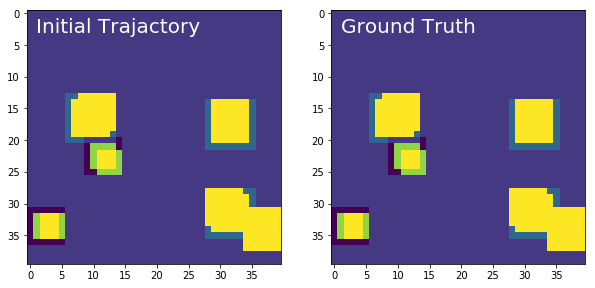

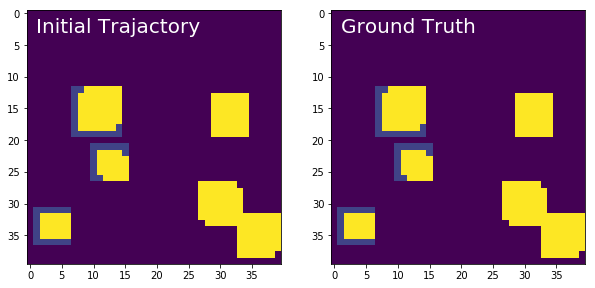

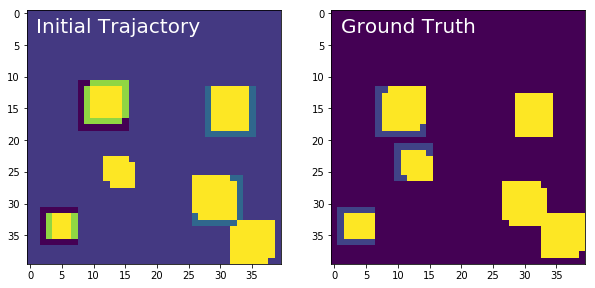

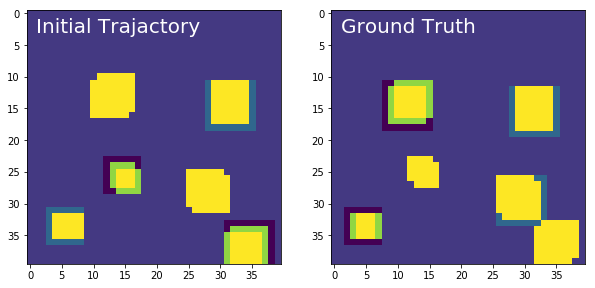

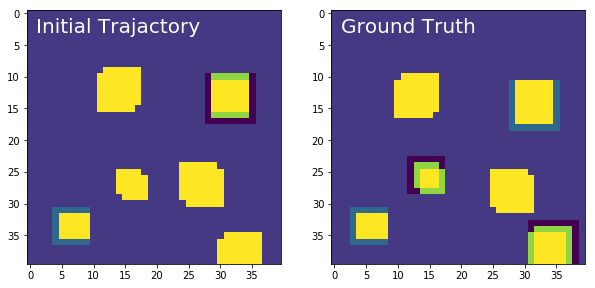

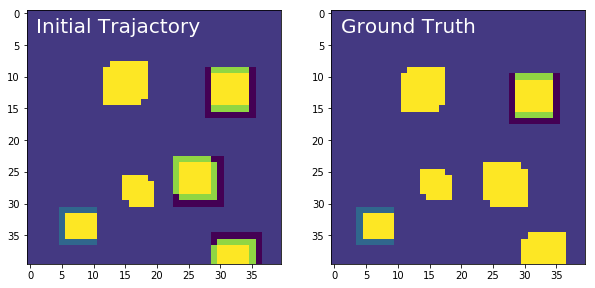

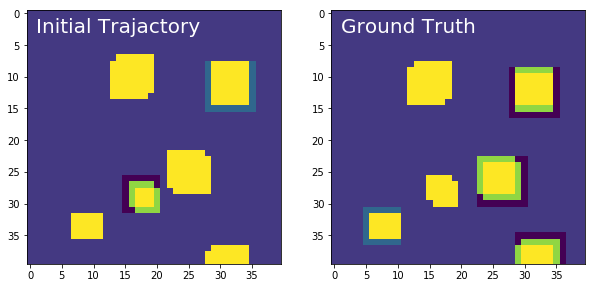

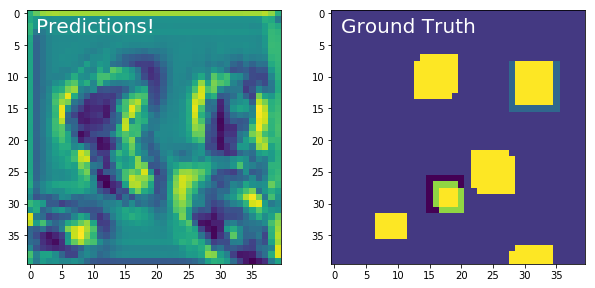

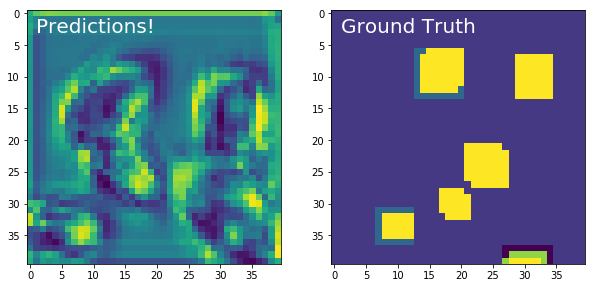

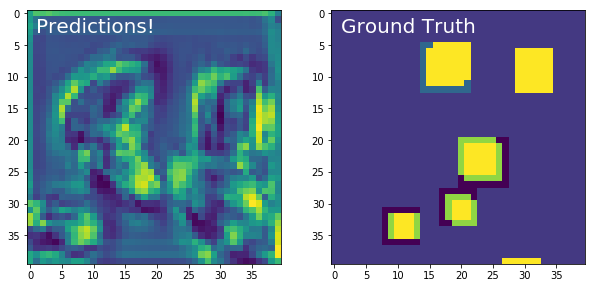

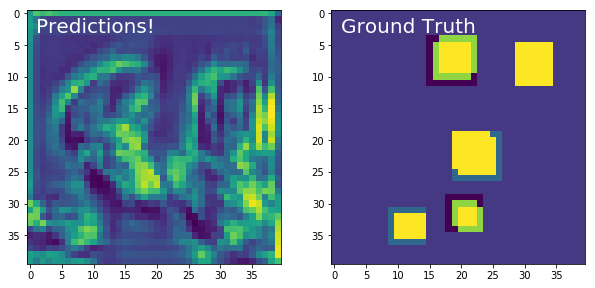

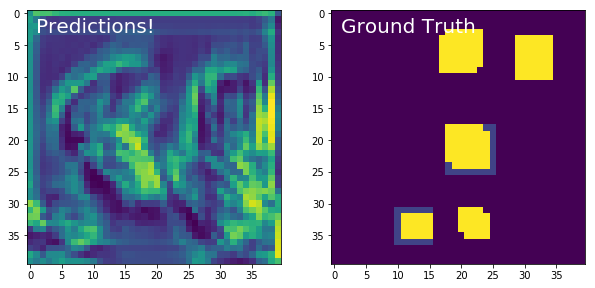

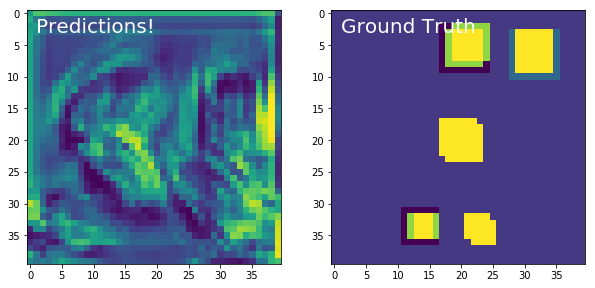

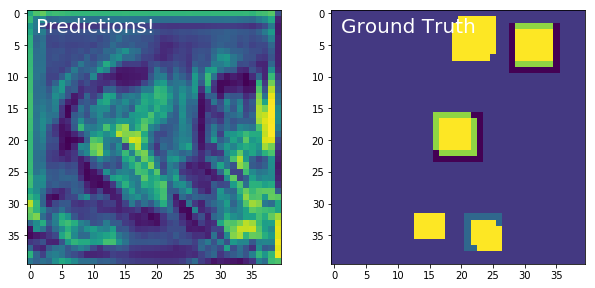

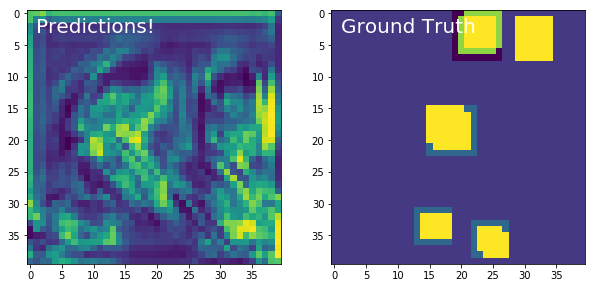

In [31]:
track2 = noisy_movies[example_mov]

for i in range(15):
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(121)
    
    if i >= 7:
        ax.text(1,3,'Predictions!', fontsize = 20, color = 'w')
    else:
        ax.text(1,3,'Initial Trajactory', fontsize = 20, color = 'w')
    
    toplot = track[i,:,:,0]
    plt.imshow(toplot)
    
    ax = fig.add_subplot(122)
    plt.text(1,3,'Ground Truth', fontsize = 20, color = 'w')
    
    toplot = track2[i,:,:,0]
    if i >= 2:
        toplot = shifted_movies[example_mov][i - 1,:,:,0]
    
    plt.imshow(toplot)
    plt.savefig('{:03d}_animate.png'.format(i + 1))

#### Save the model

In [32]:
# pass